# Modelo de regresión AutoREG y ARIMA
## Carga de librerías y carga del archivo
Nota: Se puede especificar la variable de `numero_dias_prueba` aquí para dividir el dataset en el dataset de entrenamiento y prueba

In [4]:
import datetime
from math import sqrt
import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

pd.plotting.register_matplotlib_converters()

nombre_archivo_filtrado = "datos_regresion.csv"


df_datos_covid_tungurahua = None

if os.path.exists(nombre_archivo_filtrado):
    df_datos_covid_tungurahua = pd.read_csv(nombre_archivo_filtrado, index_col = 0 ,parse_dates=True, squeeze = True)
else:
    print("Por favor, ejecute todas las celdas del anterior Notebook")
    
# Definición variables datos
numero_dias_prueba = 14

## Gráfico correlación Datos Positivos Tungurahua

Graficar el gráfico de correlación para verificar que los datos tengan correlación entre ellos y sea posible establecer un modelo de Regresión

In [2]:
series_positivo = df_datos_covid_tungurahua["positivo"]
series_positivo = series_positivo[series_positivo >=  0]
series_positivo.index = pd.DatetimeIndex(series_positivo.index.values,
                               freq=series_positivo.index.inferred_freq) #Generacion de Index
_ = pd.plotting.lag_plot(series_positivo)


## Gráfico de autocorrelación del los positivos
Obtener los valores de los lags con el fin de escoger los mejores datos

In [6]:
_ = pd.plotting.autocorrelation_plot(series_positivo)

## Modelo AutoReg
Realizar un modelo de Autoregresión y graficar sus datos, así como las métricas del RMSE, fuente de datos: 

https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

Test RMSE: 11.441


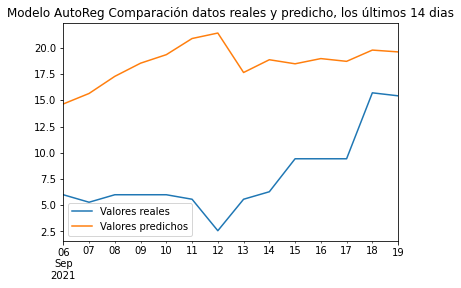

In [7]:
train, test = series_positivo[1:len(series_positivo)-numero_dias_prueba], series_positivo[len(series_positivo)-numero_dias_prueba:]
fechas_prueba = series_positivo.index[len(series_positivo)-numero_dias_prueba:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
datos_prueba_autoreg = pd.DataFrame(data={"Valores reales": test, "Valores predichos": predictions}, index=fechas_prueba)
_ = datos_prueba_autoreg.plot(title="Modelo AutoReg Comparación datos reales y predicho, los últimos {} dias".format(numero_dias_prueba))


## Modelo ARIMA
Crear un modelo ARIMA; ingresar los datos, graficar y obtener las métricas de RMSE, fuentes de como hacer el modelo:

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ 

Test RMSE: 3.777


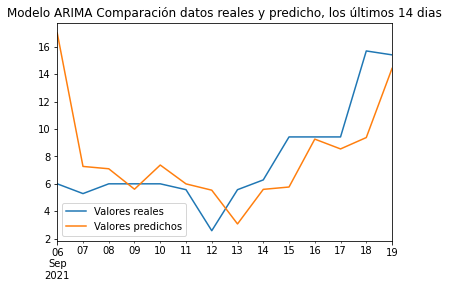

In [8]:
train, test = series_positivo[1:len(series_positivo)-numero_dias_prueba], series_positivo[len(series_positivo)-numero_dias_prueba:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
datos_prueba_arima = pd.DataFrame(data={"Valores reales": test, "Valores predichos": predictions}, index=fechas_prueba)
_ = datos_prueba_arima.plot(title="Modelo ARIMA Comparación datos reales y predicho, los últimos {} dias".format(numero_dias_prueba))


## Definición Parámetros

## Cálculo de las métricas de Entrenamiento
Métricas: 
- `mean-square-error`
- `r2-score`

In [9]:
rms_modelo_autoreg = mean_squared_error(datos_prueba_autoreg["Valores predichos"], datos_prueba_autoreg["Valores reales"])
r2_modelo_autoreg = r2_score(datos_prueba_autoreg["Valores predichos"], datos_prueba_autoreg["Valores reales"])
rms_modelo_arima = mean_squared_error(datos_prueba_arima["Valores predichos"], datos_prueba_arima["Valores reales"])
r2_modelo_arima = r2_score(datos_prueba_arima["Valores predichos"], datos_prueba_arima["Valores reales"])

## Gráfica de la predicción siguientes días

In [10]:
numero_dias_predecir = 15
series_positivo.index = pd.DatetimeIndex(series_positivo.index.values,
                               freq=series_positivo.index.inferred_freq)

ultima_fecha = pd.to_datetime(series_positivo.index[-1])

fechas_prediccion = []
for x in range(numero_dias_predecir + 1):
    fecha = ultima_fecha + datetime.timedelta(days = x)
    fechas_prediccion.append(fecha)

#Entrenar de nuevo los modelos con el dato completo
# Modelo autoregression
modelo_autoreg = AutoReg(series_positivo, lags=29)
model_autoreg_fit = modelo_autoreg.fit()
prediccion_autoreg = model_autoreg_fit.predict(start = fechas_prediccion[0], end = fechas_prediccion[-1])
#Modelo ARIMA
for i in range(numero_dias_predecir):
    modelo_ARIMA = ARIMA(series_positivo, order=(5,1,0))
    model_fit_ARIMA = modelo_ARIMA.fit()
    output = model_fit_ARIMA.forecast()
    
prediccion_arima = model_fit_ARIMA.forecast(numero_dias_predecir + 1)[0]

#Datos predicción 
datos_prueba_arima = pd.DataFrame(data={"Prediccion AutoReg": prediccion_autoreg, "Prediccion ARIMA": prediccion_arima}, index=fechas_prediccion)
_ = datos_prueba_arima.plot(title="Predicción AutoReg y ARIMA en un periodo de {} dias hasta {}".format(numero_dias_predecir, fechas_prediccion[-1]))
 

## Error cuadrático Medio

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(["RMS Modelo AutoReg", "RMS Modelo Arima"], [rms_modelo_autoreg, rms_modelo_arima])
plt.title("Valores RMS Modelos Polinomial y Lineal")
plt.ylabel("Valor")
plt.show()

## Puntaje R^2 

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(["R2 Modelo AutoReg", "R2 Modelo ARIMA"], [r2_modelo_autoreg, r2_modelo_arima])
plt.title("Valores R2 Modelos Polinomial y Lineal")
plt.ylabel("Valor")
plt.show()